<font size=10 color=pink>Multi-Classification of Cirrhosis Patients</font>

<font size=8 color=pink>About the dataset</font>

The dataset comprises 17 clinical features employed for predicting the survival of patients with liver cirrhosis. It is a multiclass classification task with three classes:

- **D (Death):** Indicates that the patient did not survive.
- **C (Censored):** Denotes that the observation period concluded without the patient succumbing.
- **CL (Censored due to Liver Transplant):** Similar to C, but in this case, the patient is censored because a liver transplant has occurred.


<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2003977%2F4465d9311ccae2f9ccb057fc7e14f26f%2FScreenshot%20from%202023-10-18%2009-42-52.png?generation=1697586187040332&alt=media" alt="Data Overview" width="600">


<font size=8 color=pink> Imports and reading data</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import logging
from sklearn.preprocessing import LabelEncoder,StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import cross_validate,KFold,train_test_split,StratifiedKFold
from sklearn.metrics import log_loss,f1_score,roc_auc_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from prettytable import PrettyTable
import time

pd.set_option('display.max_columns',100)
%matplotlib inline
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(logging.CRITICAL + 1)

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module="lightgbm")

In [3]:
train = pd.read_csv("cirrhosis_train.csv")
real = pd.read_csv("cirrhosis.csv")

In [6]:
train = pd.concat([train,real]).reset_index(drop=True)
train.drop(columns=['id','ID'],inplace=True)

<font size=8 color=pink>Data Cleaning </font>

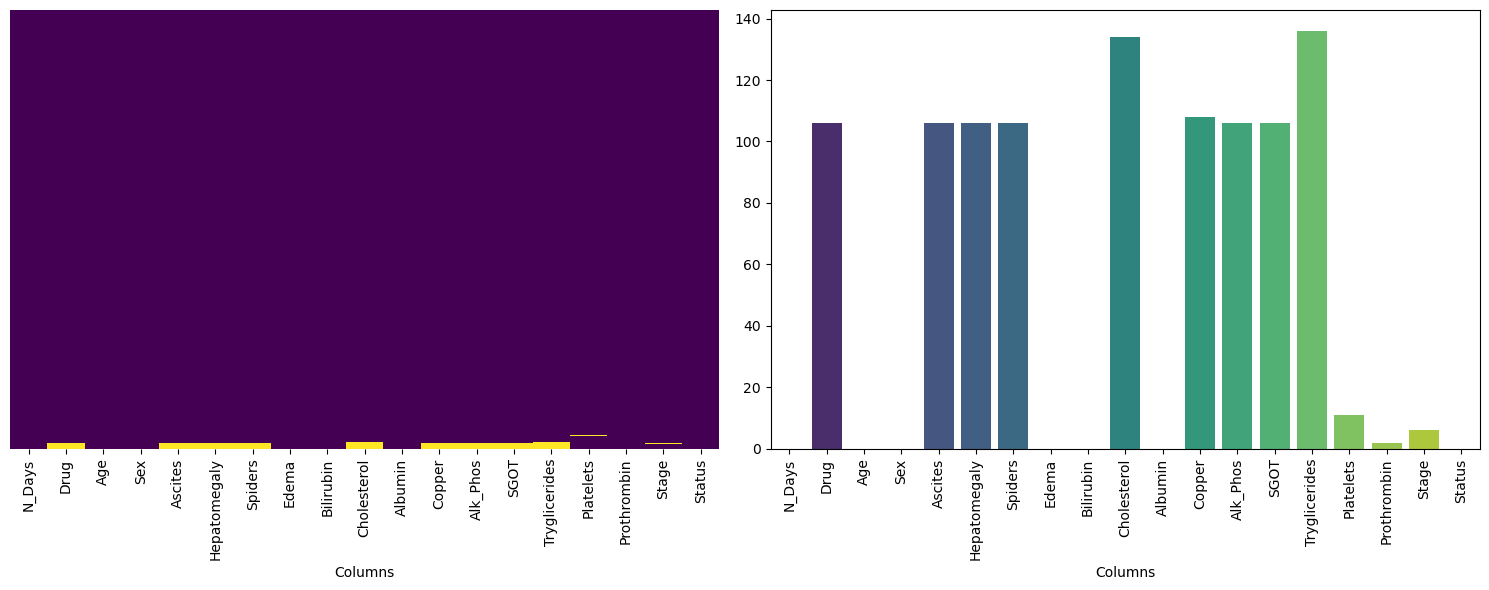

In [8]:
#looking for null values
def NullValues(df):
    '''
    This function looks for the null values in a data frame and return a heatmap indicating the null values and a barplot showing the number of missing values
    '''
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
    sns.heatmap(data=df.isnull(),yticklabels=False,ax=axes[0],cbar=False,cmap='viridis')
    sns.barplot(x=df.columns,y=df.isnull().sum(),ax=axes[1],palette='viridis')
    axes[1].set_xticklabels(labels= axes[1].get_xticklabels(), rotation=90)
    axes[1].set_xlabel("Columns")
    axes[0].set_xlabel("Columns")
    plt.tight_layout()
    plt.show()
    
NullValues(train)

we will drop the null values

In [10]:
train.dropna(inplace=True)

In [11]:
train[train.duplicated()]

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status


No duplicate values

<font size=8 color=pink>Exploratory Data Analysis  </font>

In [17]:
train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8181 entries, 0 to 8216
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         8181 non-null   int64  
 1   Drug           8181 non-null   object 
 2   Age            8181 non-null   int64  
 3   Sex            8181 non-null   object 
 4   Ascites        8181 non-null   object 
 5   Hepatomegaly   8181 non-null   object 
 6   Spiders        8181 non-null   object 
 7   Edema          8181 non-null   object 
 8   Bilirubin      8181 non-null   float64
 9   Cholesterol    8181 non-null   float64
 10  Albumin        8181 non-null   float64
 11  Copper         8181 non-null   float64
 12  Alk_Phos       8181 non-null   float64
 13  SGOT           8181 non-null   float64
 14  Tryglicerides  8181 non-null   float64
 15  Platelets      8181 non-null   float64
 16  Prothrombin    8181 non-null   float64
 17  Stage          8181 non-null   float64
 18  Status       

In [15]:
train.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000
mean,2028.452512,18366.944994,2.619423,351.260237,3.547260,84.471825,1822.813348,114.925595,115.665322,265.112333,10.633040,3.032759
std,1094.820580,3685.501456,3.844169,196.856060,0.348327,76.403770,1911.409689,49.105416,53.034271,87.658802,0.790593,0.866041
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,210.000000,10.000000,2.000000
50%,1831.000000,18701.000000,1.100000,299.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,2689.000000,20684.000000,3.000000,392.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


In [16]:
#Give us the number of unique values for each column of data 
value_count_table = PrettyTable()
value_count_table.field_names = ['Column','Number of unique values','Type of column']
for col in train:
    n = train[col].nunique()
    if n <= 20:
        col_type = 'categorical'
    else:
        if train[col].dtype == 'O':
            col_type = 'String Column'
        else:
            col_type ='numerical'
        
    value_count_table.add_row([col,n,col_type])
    
print(value_count_table)

+---------------+-------------------------+----------------+
|     Column    | Number of unique values | Type of column |
+---------------+-------------------------+----------------+
|     N_Days    |           461           |   numerical    |
|      Drug     |            2            |  categorical   |
|      Age      |           391           |   numerical    |
|      Sex      |            2            |  categorical   |
|    Ascites    |            2            |  categorical   |
|  Hepatomegaly |            2            |  categorical   |
|    Spiders    |            2            |  categorical   |
|     Edema     |            3            |  categorical   |
|   Bilirubin   |           111           |   numerical    |
|  Cholesterol  |           226           |   numerical    |
|    Albumin    |           160           |   numerical    |
|     Copper    |           171           |   numerical    |
|    Alk_Phos   |           364           |   numerical    |
|      SGOT     |       

In [26]:
#Dividing all the features into categories
cat_cols = ['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema','Stage']
numeric_cols = ['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT',
                'Tryglicerides','Platelets','Prothrombin']
target = 'Status'
original_col = train.columns

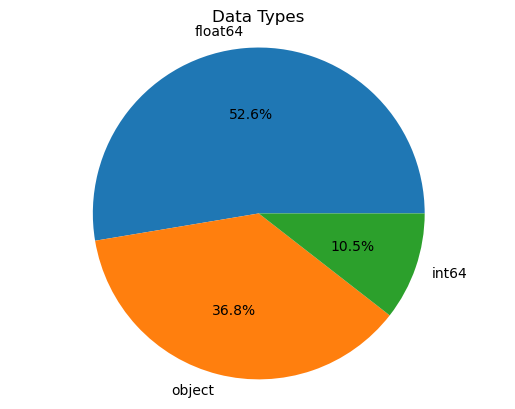

In [19]:
#looking at the data types present in the data
def GetDataType(df):
    plt.pie(df.dtypes.value_counts().values,labels=df.dtypes.value_counts().index,autopct='%1.1f%%')
    plt.title("Data Types")
    plt.axis('equal')
    plt.show()
    
GetDataType(train)

In [20]:
def Categorical(df,cat_cols,n_cols=3):
    number_cols = len(df[cat_cols].columns)
    if(number_cols % n_cols == 0):
        n_rows=int(number_cols/n_cols)
    else:
        n_rows = number_cols//n_cols +1
    fig,axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(4*n_cols,4*n_rows))
    axes= axes.flatten()
      
    for i, col in enumerate(cat_cols):
        values = df[col].value_counts()
        axes[i].pie(values,labels=values.index,autopct="%0.1f%%",shadow=True,textprops={'size':15,'color':'black'},
                    explode = [0.05] * len(df[col].unique()))
        axes[i].set_aspect = 'equal'
        axes[i].set_title(f'Distribution of {col}')
        
    plt.tight_layout()
    plt.show()
    

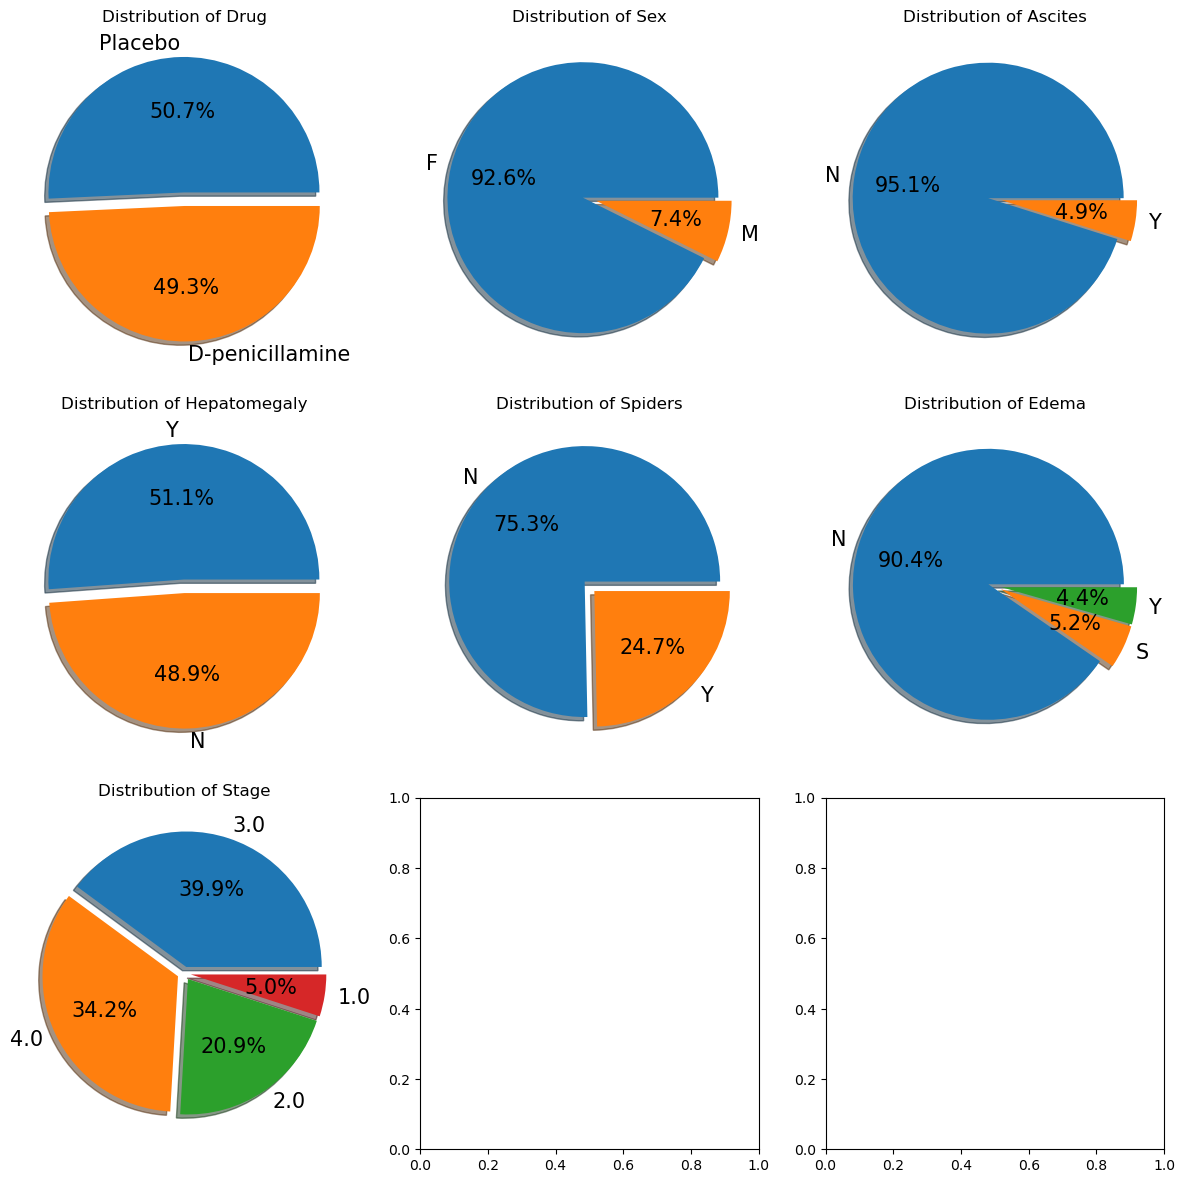

In [21]:
Categorical(train,cat_cols)

In [22]:
def ContingencyTables(df,col):
    for col in col:
        contingency_table = pd.crosstab(df[col],df[target],normalize='index')
        contingency_table.plot(kind='bar',stacked=True,figsize=(15,4))
        plt.title(f"Percentage Distribution of Target across {col}")
        plt.xlabel(col)
        plt.ylabel("Percentage")
        plt.legend(title="Churn Class")
        plt.show()

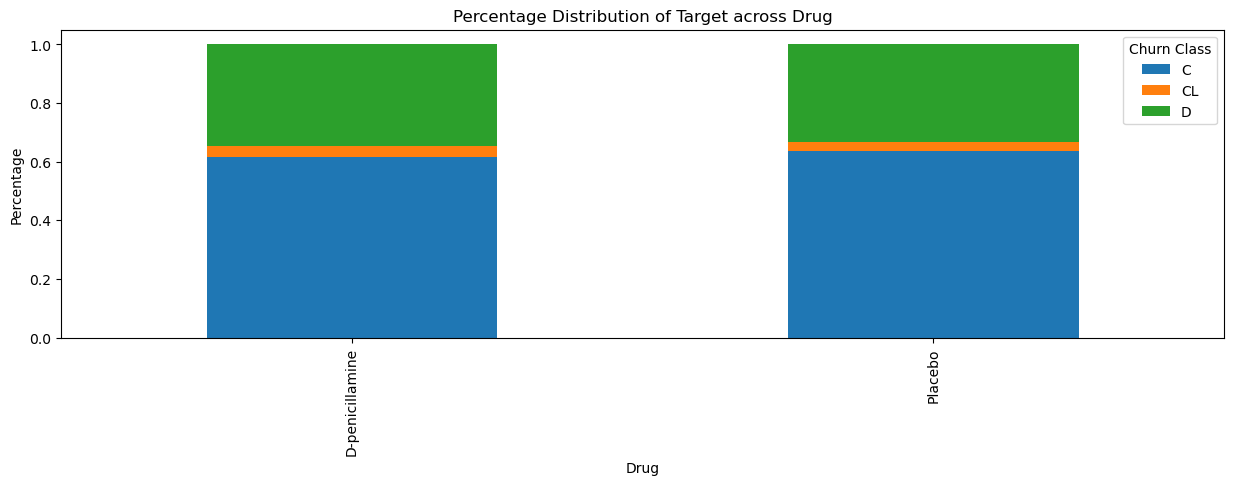

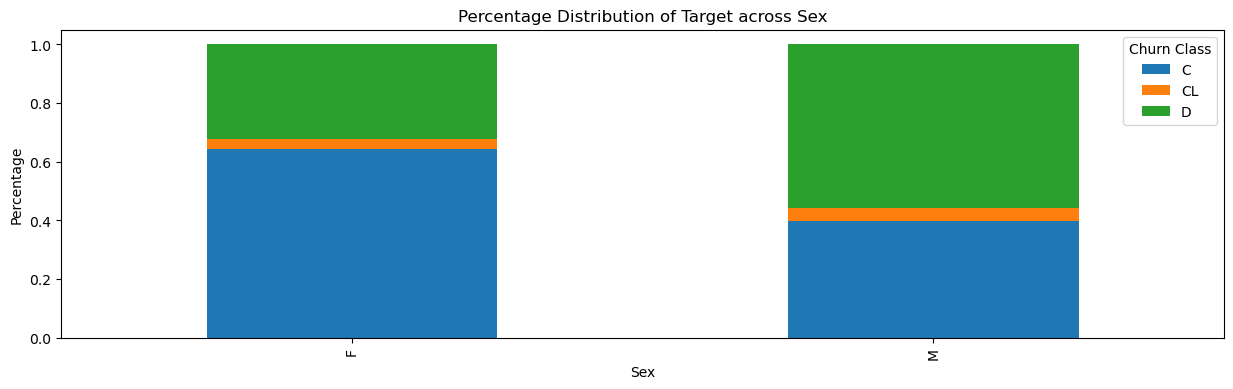

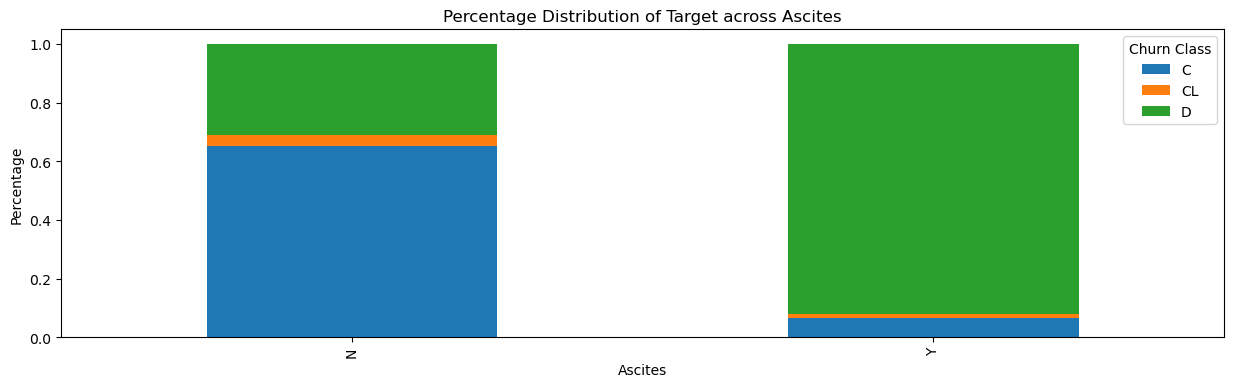

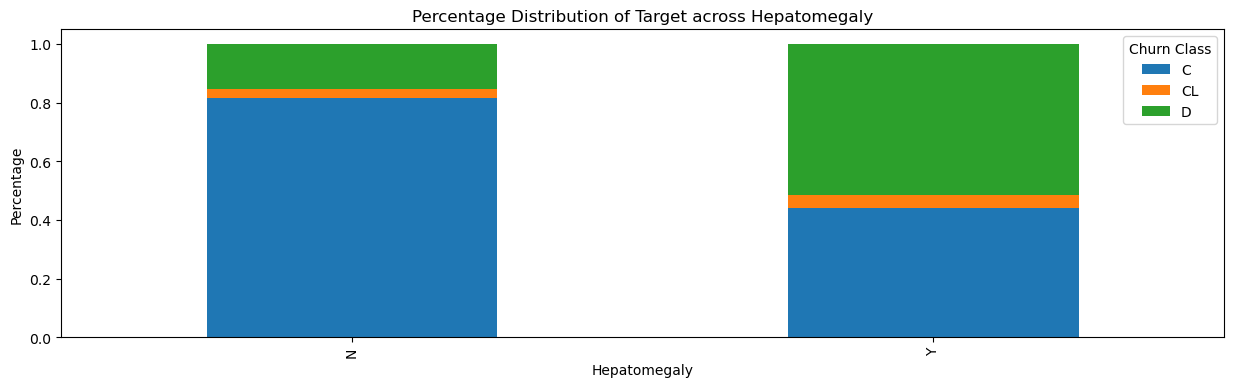

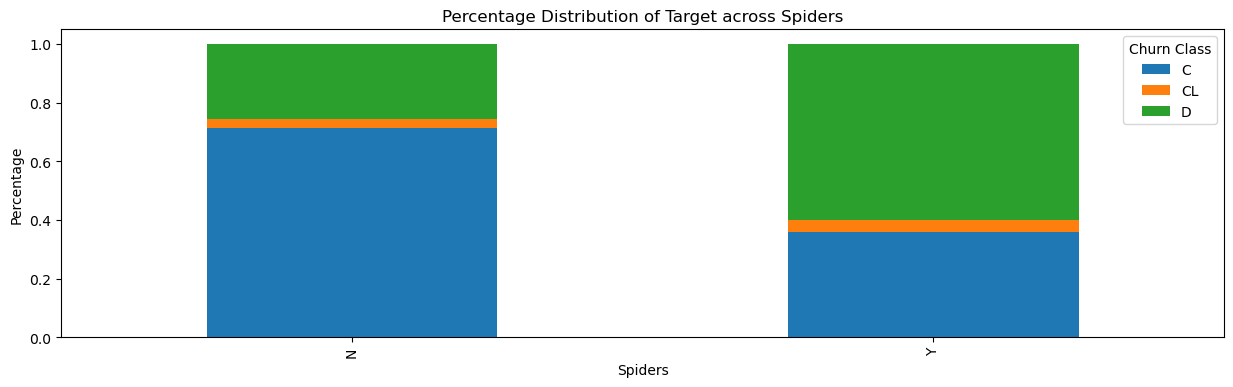

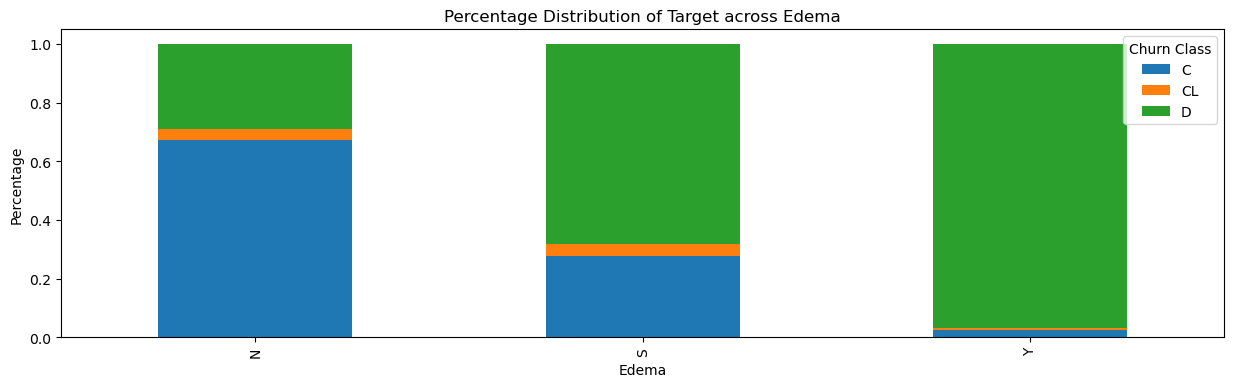

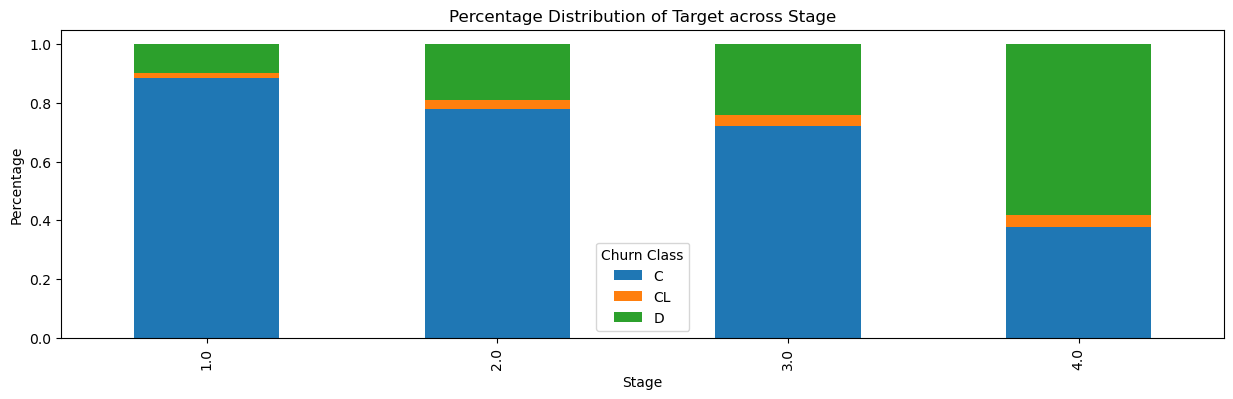

In [23]:
ContingencyTables(train,cat_cols)

In [24]:
def violin_plot(train_df,n_cols=3):
    number_cols = len(train_df.columns)
    if(number_cols % n_cols == 0):
        n_rows=int(number_cols/n_cols)
    else:
        n_rows = number_cols//n_cols +1
    fig,axs = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(4*n_cols,4*n_rows))
    axs= axs.flatten()
    
    for i, col in enumerate(numeric_cols):
        sns.violinplot(x=target, y=col, data=train, ax=axs[i])
        axs[i].set_title(f'{col.title()} Violin Plot', fontsize=14)
        axs[i].set_xlabel('Churn', fontsize=12)
        axs[i].set_ylabel(col.title(), fontsize=12)
        sns.despine()
        
        
    plt.tight_layout()
    plt.show()

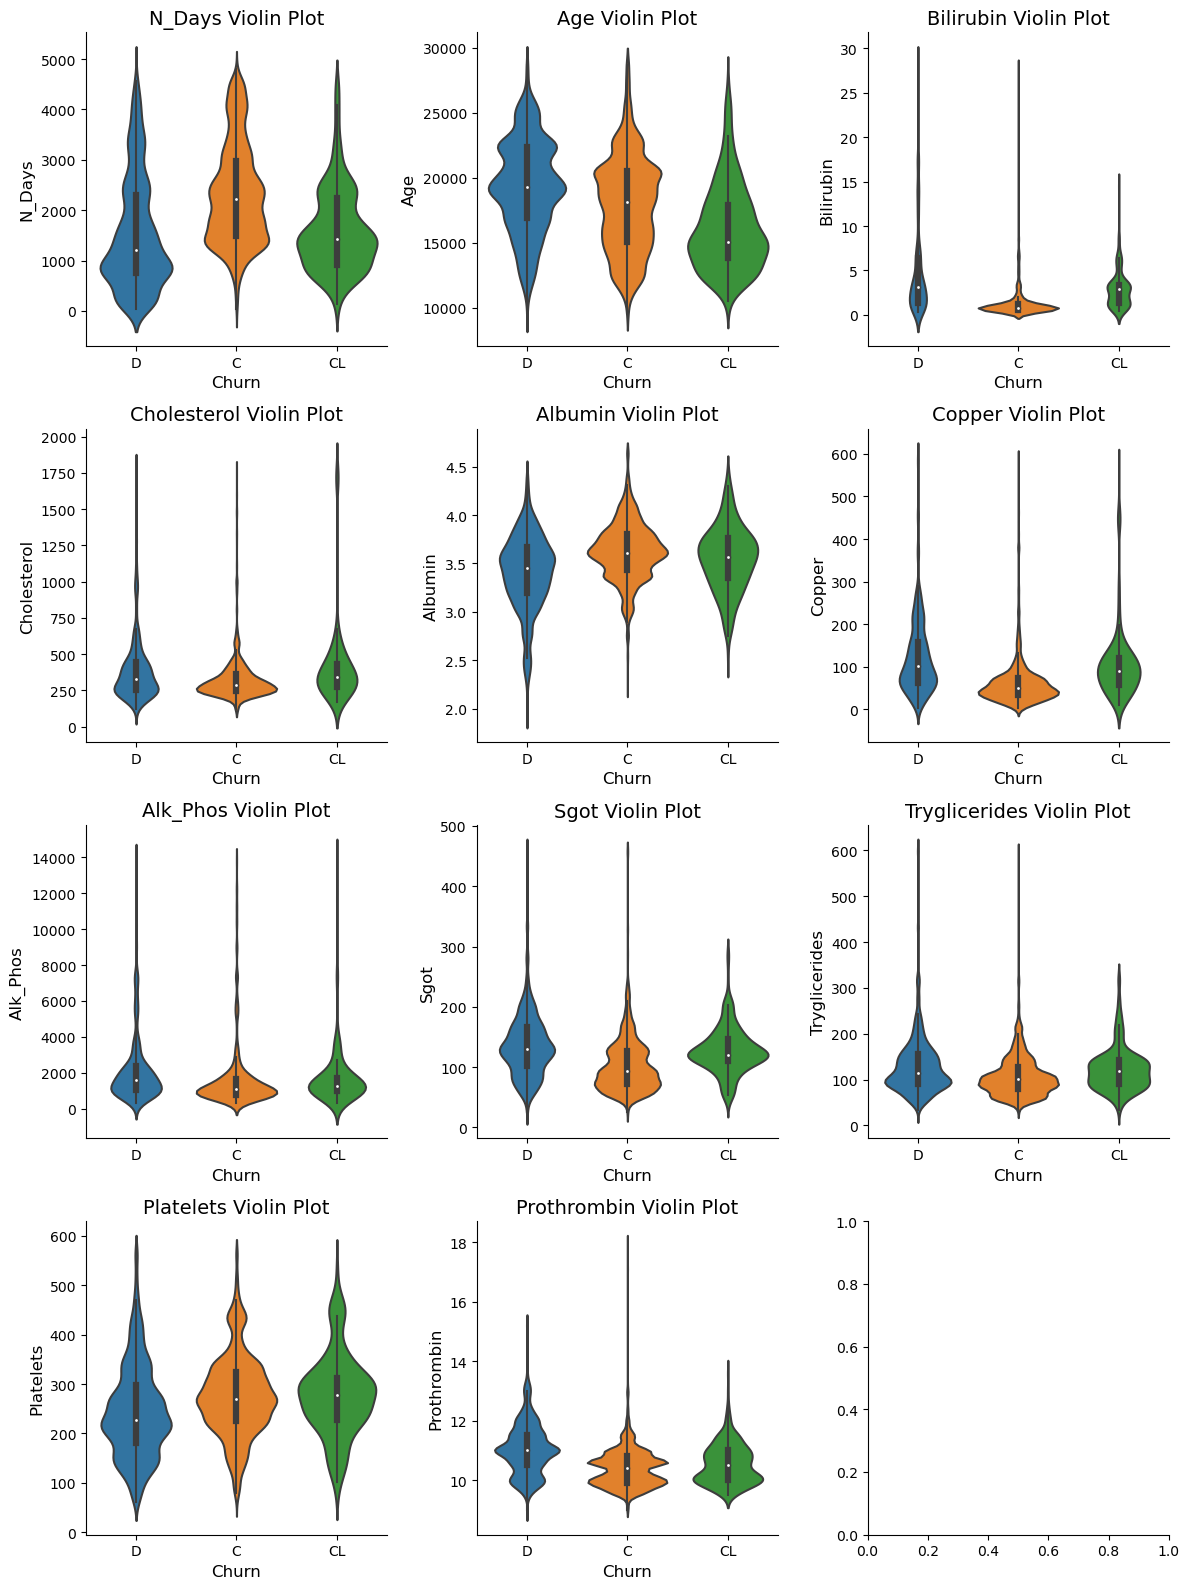

In [27]:
violin_plot(train[numeric_cols])

<font size=8 color=pink> Feature Engineering   </font>

In [30]:
#Encoding the target column
target_mapping = {'D':0,'C':1,'CL':2}
train['Status'] = train['Status'].map(target_mapping)

In [46]:
y = train['Status']

In [33]:
#OneHotEncoding Edemna and stage
train[['N_Edema','S_Edema','Y_Edema']] = pd.get_dummies(train['Edema']).astype('int64')
train[['Stage1','Stage2','Stage3','Stage4']] = pd.get_dummies(train['Stage']).astype('int64')

In [38]:
train.drop(columns=['Edema'],inplace=True)

In [36]:
#Label Encode the binary/ordinal columns
label_encoder = LabelEncoder()
label_cols = ['Drug','Sex','Ascites','Hepatomegaly','Spiders']
for i in label_cols:
    train[i]  = label_encoder.fit_transform(train[i])

In [39]:
train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,N_Edema,S_Edema,Y_Edema,Stage1,Stage2,Stage3,Stage4
0,999,0,21532,1,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0,1,0,0,0,0,1,0
1,2574,1,19237,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,1,1,0,0,0,0,1,0
2,3428,1,13727,0,0,1,1,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,0,0,0,1,0,0,0,1
3,2576,1,18460,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,1,1,0,0,0,0,1,0
4,788,1,16658,0,0,1,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,1,1,0,0,0,0,0,1


<font size=8 color=pink> Feature Selection   </font>

In [40]:
train.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status',
       'N_Edema', 'S_Edema', 'Y_Edema', 'Stage1', 'Stage2', 'Stage3',
       'Stage4'],
      dtype='object')

In [41]:
final_cols = ['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage',
       'N_Edema', 'S_Edema', 'Y_Edema', 'Stage1', 'Stage2', 'Stage3',
       'Stage4']

In [42]:
def CorrelationFeatures(df,title=""):
    '''
    Function to get correlation heat map
    '''
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,16))
    sns.heatmap(data=df.astype(float).corr(),linecolor='white',linewidths=0.1,annot=True,annot_kws={'size':8,'color':'black','weight':'bold'},cmap='viridis',
                vmin=-1.0,vmax=1.0,square=True,mask=mask)
    plt.title(f"Correlation of {title} features")
    plt.show()

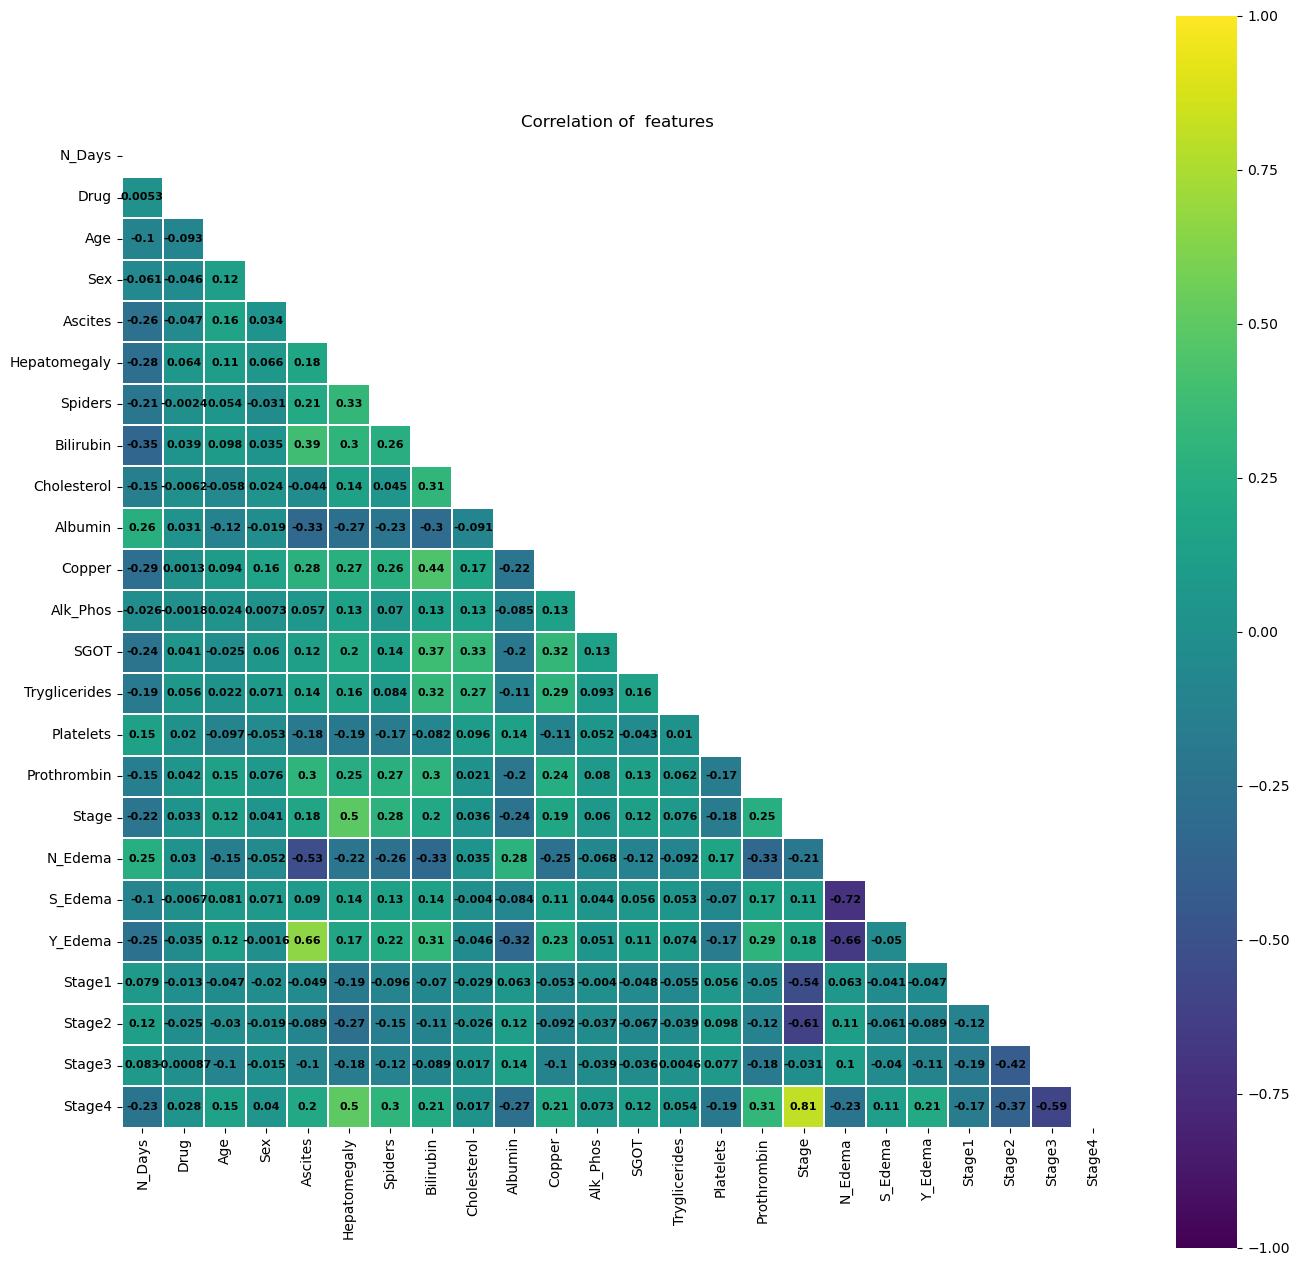

In [43]:
CorrelationFeatures(train[final_cols])

No features are that correlated so we can use them all

<font size=8 color=pink> Scaling Data  </font>

In [44]:
#Scaling the data 
def ScaleData(train):
    scaler = StandardScaler()

    X = scaler.fit_transform(train)
    X = pd.DataFrame(X)
    X.columns = train.columns
    
    
    return X 

In [45]:
X = ScaleData(train[final_cols])

<font size=8 color=pink> Splitting Data   </font>

We will split the data into 2 parts. One part will be used to train the data, that part will be trained with cross validation. The second part will be used to only evaluate the model 

In [47]:
X_train , X_test, y_train , y_test = train_test_split(X,y,test_size=0.2)

In [48]:
X_train.shape

(6544, 24)

In [49]:
y_train.shape

(6544,)

In [50]:
X_test.shape

(1637, 24)

In [51]:
y_test.shape

(1637,)

<font size=8 color=pink> Model Selection   </font>

To select a model we will create a cross validation stratergy and then test the model on accuracy and log loss

In [52]:
#Making a cross validation
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [68]:
def CrossValidate(clf,X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    scores = PrettyTable()
    scores.field_names = ['Fold','Accuracy','log_loss','Confusion Matrix','time to train']
    conf_matrices = []
    accuracies = []
    log_loss_scores = []
    training_times = []
    for  train_index, test_index in kf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        start = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        accuracies.append(round(accuracy_score(y_test, y_pred),5))
        log_loss_scores.append(round(log_loss(y_test, y_prob),5))
        end = time.time()
        training_times.append(round(end-start,2))

    for i in range(10):
        scores.add_row([(i+1),accuracies[i],log_loss_scores[i],conf_matrices[i],training_times[i]])

    print(scores)
    print(f"Mean accuracy - {sum(accuracies) / 10}")
    print(f"Mean log_loss - {sum(log_loss_scores) / 10}") 
    
    return accuracies , log_loss_scores
    

In [54]:
def FeatureImp(model):
    fi = model.feature_importances_
    sorted_idx = np.argsort(fi).tolist()
    plt.figure(figsize=(8,8))
    plt.barh(range(len(sorted_idx)), fi[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [final_cols[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

<font size=5 color=pink> XG Boost</font>

In [65]:
xg_params = {
    'objective':'multiclass',
    'n_estimators': 643,
 'learning_rate': 0.04462200585423764,
 'max_depth': 6,
 'subsample': 0.6198137500418566,
 'colsample_bytree': 0.1522650912835547,
 'min_child_weight': 16}

In [66]:
xg = XGBClassifier(**xg_params)

In [70]:
xg_accuracy, xg_logloss = CrossValidate(xg,X_train,y_train)

+------+----------+----------+------------------+---------------+
| Fold | Accuracy | log_loss | Confusion Matrix | time to train |
+------+----------+----------+------------------+---------------+
|  1   |  0.8458  | 0.41427  |  [[162  55   1]  |      1.43     |
|      |          |          |   [ 25 387   1]  |               |
|      |          |          |  [  7  12   5]]  |               |
|  2   | 0.85191  | 0.44286  |  [[173  45   0]  |      1.36     |
|      |          |          |   [ 33 379   1]  |               |
|      |          |          |  [  7  11   6]]  |               |
|  3   | 0.83969  | 0.41463  |  [[171  46   1]  |      1.36     |
|      |          |          |   [ 37 375   1]  |               |
|      |          |          |  [  7  13   4]]  |               |
|  4   | 0.83053  | 0.44477  |  [[165  53   1]  |      1.39     |
|      |          |          |   [ 37 371   4]  |               |
|      |          |          |  [  5  11   8]]  |               |
|  5   | 0

In [71]:
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1522650912835547, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04462200585423764,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=16, missing=nan, monotone_constraints=None,
              n_estimators=643, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

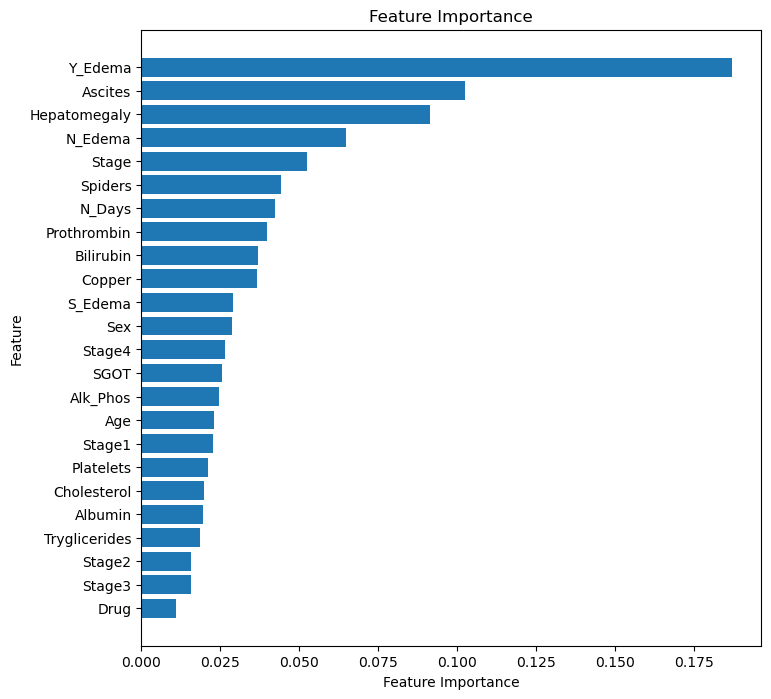

In [72]:
FeatureImp(xg)

<font size=5 color=pink> Light Gradient Boost   </font>

In [82]:
lgbm_params = {'max_depth': 11,
 'min_child_samples': 7,
 'learning_rate': 0.0436924370242952,
 'n_estimators': 214,
 'min_child_weight': 7,
 'subsample': 0.7087359687137316,
 'colsample_bytree': 0.5171033709359893,
 'reg_alpha': 0.0374734188470864,
 'reg_lambda': 7.109640245594749,
 'num_leaves': 90,
   'verbose':-1}

In [83]:
lgbm = LGBMClassifier(**lgbm_params)

In [84]:
lgbm_accuracy, lgbm_logloss = CrossValidate(lgbm,X_train,y_train)

+------+----------+----------+------------------+---------------+
| Fold | Accuracy | log_loss | Confusion Matrix | time to train |
+------+----------+----------+------------------+---------------+
|  1   | 0.83817  | 0.42797  |  [[160  57   1]  |      0.52     |
|      |          |          |   [ 28 384   1]  |               |
|      |          |          |  [  8  11   5]]  |               |
|  2   | 0.83511  | 0.44339  |  [[165  53   0]  |      0.5      |
|      |          |          |   [ 35 377   1]  |               |
|      |          |          |  [  8  11   5]]  |               |
|  3   |  0.8458  |  0.412   |  [[170  47   1]  |      0.5      |
|      |          |          |   [ 34 377   2]  |               |
|      |          |          |  [  6  11   7]]  |               |
|  4   | 0.82443  | 0.45635  |  [[164  54   1]  |      0.5      |
|      |          |          |   [ 38 369   5]  |               |
|      |          |          |  [  3  14   7]]  |               |
|  5   | 0

In [85]:
lgbm.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.5171033709359893,
               learning_rate=0.0436924370242952, max_depth=11,
               min_child_samples=7, min_child_weight=7, n_estimators=214,
               num_leaves=90, reg_alpha=0.0374734188470864,
               reg_lambda=7.109640245594749, subsample=0.7087359687137316,
               verbose=-1)

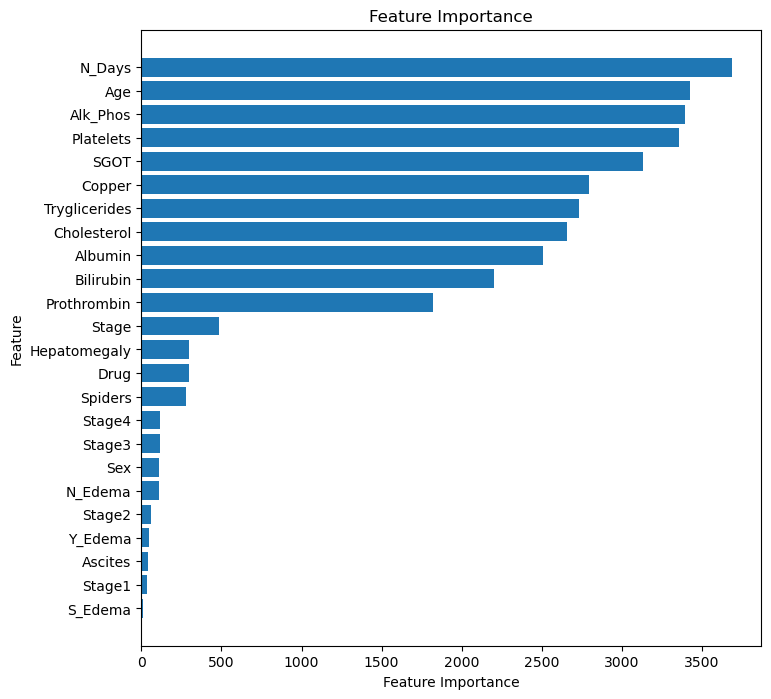

In [86]:
FeatureImp(lgbm)

<font size=5 color=pink> Cat Boost   </font>

In [88]:
cat_params  = {'iterations': 585,
 'depth': 12,
 'min_data_in_leaf': 8,
 'learning_rate': 0.04731181707647074,
 'grow_policy': 'Lossguide',
 'bootstrap_type': 'Bayesian',
  'logging_level':'Silent'
            }

In [89]:
cat = CatBoostClassifier(**cat_params)

In [92]:
cat_accuracy, cat_logloss = CrossValidate(cat,X_train,y_train)

+------+----------+----------+------------------+---------------+
| Fold | Accuracy | log_loss | Confusion Matrix | time to train |
+------+----------+----------+------------------+---------------+
|  1   | 0.84733  | 0.42574  |  [[165  53   0]  |      2.98     |
|      |          |          |   [ 28 385   0]  |               |
|      |          |          |  [  8  11   5]]  |               |
|  2   | 0.83969  | 0.44255  |  [[168  50   0]  |      3.14     |
|      |          |          |   [ 33 380   0]  |               |
|      |          |          |  [ 11  11   2]]  |               |
|  3   | 0.84275  | 0.41297  |  [[172  46   0]  |      2.98     |
|      |          |          |   [ 34 378   1]  |               |
|      |          |          |  [  9  13   2]]  |               |
|  4   |  0.8229  | 0.45298  |  [[162  57   0]  |      3.15     |
|      |          |          |   [ 36 372   4]  |               |
|      |          |          |  [  5  14   5]]  |               |
|  5   | 0

In [93]:
cat.fit(X_train,y_train)

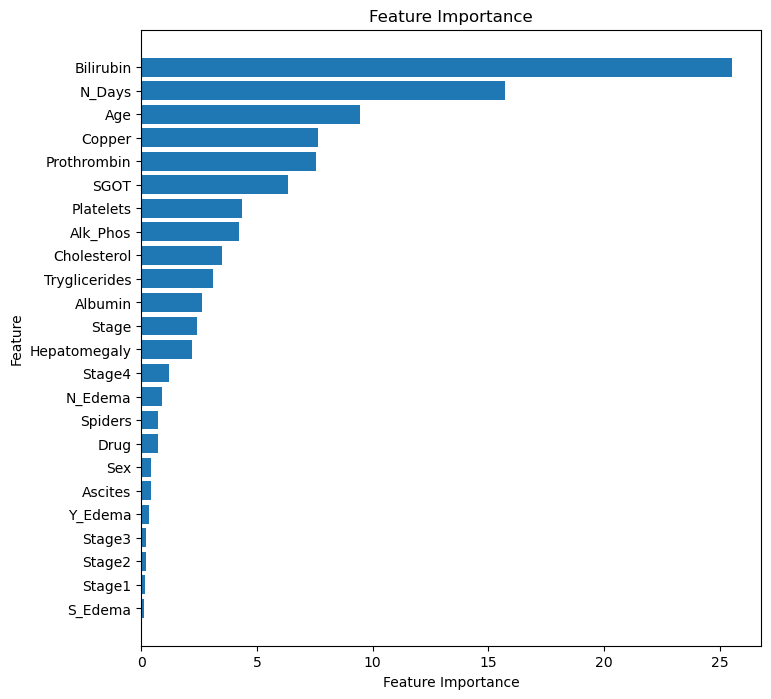

In [94]:
FeatureImp(cat)

<font size=8 color=pink>Voting Ensemble</font>

In [95]:
voting = VotingClassifier(estimators=[('lgbm',lgbm),('xg',xg),('cat',cat)],voting='soft')

In [96]:
voting_accuracy, voting_logloss = CrossValidate(voting,X_train,y_train)

+------+----------+----------+------------------+---------------+
| Fold | Accuracy | log_loss | Confusion Matrix | time to train |
+------+----------+----------+------------------+---------------+
|  1   | 0.84733  | 0.41579  |  [[162  55   1]  |      4.89     |
|      |          |          |   [ 24 388   1]  |               |
|      |          |          |  [  8  11   5]]  |               |
|  2   | 0.84733  | 0.43512  |  [[169  49   0]  |      5.04     |
|      |          |          |   [ 31 381   1]  |               |
|      |          |          |  [  8  11   5]]  |               |
|  3   |  0.8458  | 0.40706  |  [[172  45   1]  |      5.23     |
|      |          |          |   [ 34 378   1]  |               |
|      |          |          |  [  7  13   4]]  |               |
|  4   | 0.82443  | 0.44396  |  [[165  53   1]  |      5.5      |
|      |          |          |   [ 39 369   4]  |               |
|      |          |          |  [  4  14   6]]  |               |
|  5   | 0

In [97]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.5171033709359893,
                                             learning_rate=0.0436924370242952,
                                             max_depth=11, min_child_samples=7,
                                             min_child_weight=7,
                                             n_estimators=214, num_leaves=90,
                                             reg_alpha=0.0374734188470864,
                                             reg_lambda=7.109640245594749,
                                             subsample=0.7087359687137316,
                                             verbose=-1)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=No...
                                            learning_rate=0.04462200585423764,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=16, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=643, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000023EB0B48520>)],
                 voting='soft')

<font size=8 color=pink> Model Evaluation   </font>

In [98]:
preds = voting.predict(X_test)
preds_prob = voting.predict_proba(X_test)

In [99]:
accuracy = accuracy_score(y_test,preds)
ll = log_loss(y_test,preds_prob)

In [100]:
print(f"Accuracy - {accuracy} \nLog loss - {ll}")

Accuracy - 0.8210140500916311 
Log loss - 0.4564046984540956


In [101]:
confusion = confusion_matrix(y_test,preds)

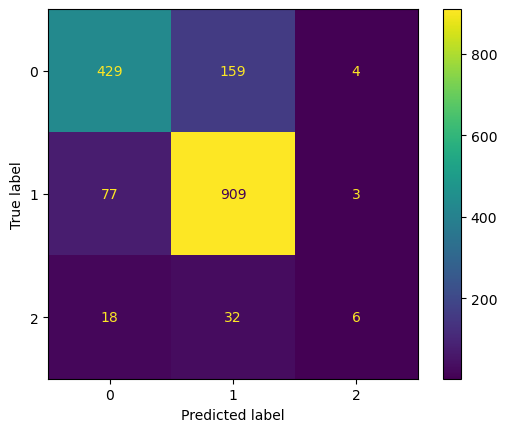

In [102]:
confusion_figure = ConfusionMatrixDisplay(confusion_matrix=confusion)
confusion_figure.plot()
plt.show()